In [30]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [31]:
customers =  pd.read_csv('customers.csv',encoding="ISO-8859-1")

In [32]:
orders =  pd.read_csv('orders.csv',encoding="ISO-8859-1")

In [33]:
orders.drop_duplicates(inplace = True)

In [34]:
customers.drop_duplicates(inplace = True)

In [35]:
orders = orders[(orders.customer_id.notnull()) & (orders.sales!=0)]

In [36]:
orders['order_date'] = pd.to_datetime(orders['order_date'],infer_datetime_format=True)

In [37]:
orders['month'] = orders['order_date'].dt.strftime('%Y-%m') 

In [38]:
orders = orders[(orders.month > '2015-12') & (orders.sales!=0)]

In [39]:
cohorts= orders.groupby('customer_id',as_index=False)['month'].min()
cohorts.rename(columns = {'month':'cohort'},inplace=True)
cohorts.head()

,customer_id,cohort
0,AA-10315,2016-03
1,AA-10375,2016-07
2,AA-10480,2016-07
3,AA-10645,2016-07
4,AB-10015,2016-11


In [40]:
orders_merged = pd.merge(orders, cohorts, how = 'left', on = 'customer_id')

In [41]:
def cohort_period(df):
    """
    Creates column CohortPeriod
    """
    df['CohortPeriod'] = np.arange(len(df))
    return df

In [42]:
cohorts_group = orders_merged.groupby(['cohort', 'month']).agg({'customer_id': pd.Series.nunique})
cohorts_group.rename(columns={'customer_id': 'TotalUsers',
                        'id': 'TotalOrders'}, inplace=True)
cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['cohort', 'CohortPeriod'], inplace=True) 
cohort_group_size = cohorts_group['TotalUsers'].groupby(level=0).first()
user_retention = cohorts_group['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)



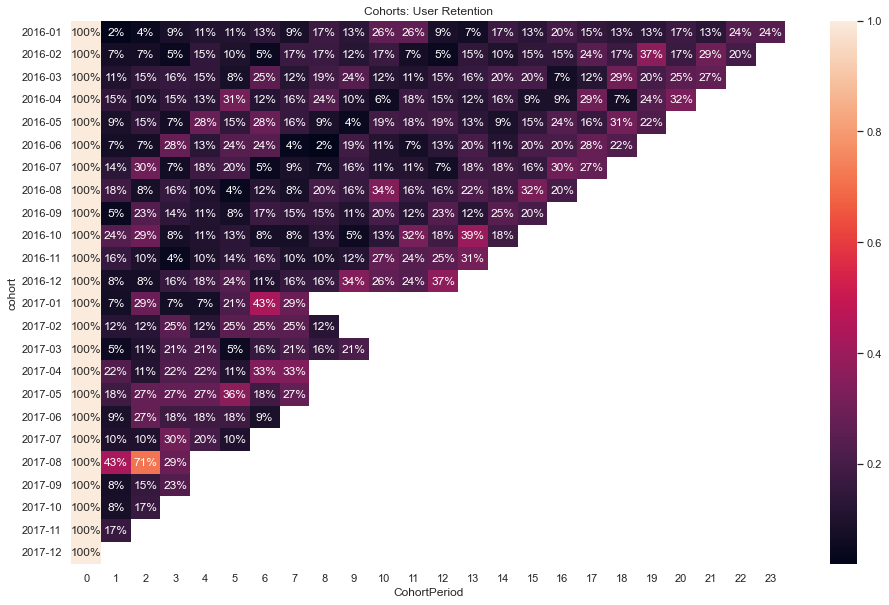

In [43]:
sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

Рассмотрим первые 12 горизонталей. В них данные по 12 когортам 2016 года
В конце 2016 года значения на диагонали близки к 0, в то время, как в 2017 году retention rate пользователей данных когорт превосходит 20% и показатели в целом выше, чем в 2016 году.

Если же сравнивать показатели когорт 2016 года в конце 2016 года с когортами 2017 года в конце 2017 года, то ухудшений тоже не наблюдается, за исключением аномалии когорты января 17го года, когда пропали данные по когорте. Для когорт 2017 года в конце 2017 года показатели в целом выше, чем для когорт 16го года в конце 16го года, что в целом говорит об улучшении удержания покупателей в новом году